# Classification Models
***

In [1]:
# Import necessary libraries/packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import itertools
from sklearn import metrics

from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV, cross_val_score)

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
                              
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,
RandomForestRegressor)

from sklearn.metrics import (classification_report, confusion_matrix, 
                             plot_confusion_matrix, precision_score, 
                             accuracy_score, recall_score, f1_score, roc_curve, 
                             auc)

from functions import *

***
# Preprocessing data
***

In [2]:
# Load dataset and ceate pd dataframes
raw_df = pd.read_csv('../DATA/data.csv')

In [3]:
raw_df.describe().round(2)

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00
mean,0.53,1976.79,0.50,0.54,230948.31,0.48,0.08,0.17,5.20,0.21,-11.47,0.71,31.43,0.10,116.86
std,0.26,25.92,0.38,0.18,126118.41,0.27,0.28,0.31,3.52,0.17,5.70,0.46,21.83,0.16,30.71
min,0.00,1921.00,0.00,0.00,5108.00,0.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00
25%,0.32,1956.00,0.10,0.42,169827.00,0.26,0.00,0.00,2.00,0.10,-14.62,0.00,11.00,0.03,93.42
50%,0.54,1977.00,0.52,0.55,207467.00,0.47,0.00,0.00,5.00,0.14,-10.58,1.00,33.00,0.04,114.73
75%,0.75,1999.00,0.89,0.67,262400.00,0.70,0.00,0.10,8.00,0.26,-7.18,1.00,48.00,0.08,135.54
max,1.00,2020.00,1.00,0.99,5403500.00,1.00,1.00,1.00,11.00,1.00,3.86,1.00,100.00,0.97,243.51


In [4]:
raw_df.shape

(170653, 19)

## Popularity Distribution
Using classification models, I want to predict the popularity of a song given the features of tha data set. This data set includes a column for song popularity, which is ranges from 0-100, with 100 being the most popular. I will plot the popularity distribution of these scores. 

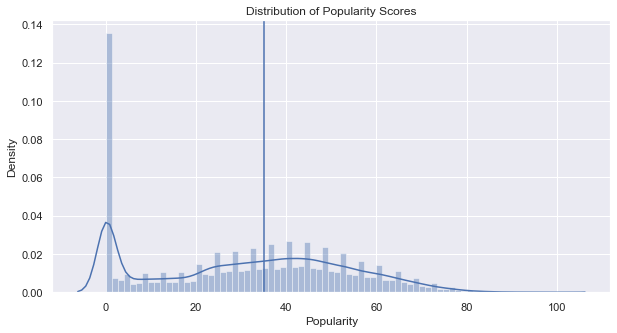

In [5]:
fig = plt.figure(figsize=(10,5))
sns.set(style="darkgrid") 
sns.distplot(raw_df['popularity'], label="Popularity", bins='auto')
plt.xlabel("Popularity")
plt.ylabel("Density")
plt.title("Distribution of Popularity Scores")
plt.axvline(35)
plt.show()

## Create caterogrical (binary) target
In order to create a variable to be the target of this classification analysis, I decided to use a popularity of 35 as a threshold value. In this step, I will create a new binary column named "popular". This column will have a threshold of 35 popularity. If the song popularity is greater than or equal to 35, then it will be classified a popular song (1). Otherwise, the song is not popular (0). I will build other models that have different threshold values and compare model performance.

In [6]:
raw_df['popular'] = (raw_df['popularity'] >= 35).astype('int')
raw_df['popular'].value_counts(1)

0    0.516838
1    0.483162
Name: popular, dtype: float64

In [7]:
raw_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,popular
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,0
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,0
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,0
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,0
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,0


In [8]:
# Save raw dataframe with 'popular column' as csv file and store in DATA folder
raw_df.to_csv('../DATA/raw_df.csv') 

## Make a new dataframe with necessary information

In [9]:
df = raw_df[['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
             'energy', 'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'tempo', 'key', 'popular']]

In [10]:
df.head()

,valence,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,key,popular
0,0.0594,1921,0.982,0.279,831667,0.211,0.878000,0.665,-20.096,0.0366,80.954,10,0
1,0.9630,1921,0.732,0.819,180533,0.341,0.000000,0.160,-12.441,0.4150,60.936,7,0
2,0.0394,1921,0.961,0.328,500062,0.166,0.913000,0.101,-14.850,0.0339,110.339,3,0
3,0.1650,1921,0.967,0.275,210000,0.309,0.000028,0.381,-9.316,0.0354,100.109,5,0
4,0.2530,1921,0.957,0.418,166693,0.193,0.000002,0.229,-10.096,0.0380,101.665,3,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   danceability      170653 non-null  float64
 4   duration_ms       170653 non-null  int64  
 5   energy            170653 non-null  float64
 6   instrumentalness  170653 non-null  float64
 7   liveness          170653 non-null  float64
 8   loudness          170653 non-null  float64
 9   speechiness       170653 non-null  float64
 10  tempo             170653 non-null  float64
 11  key               170653 non-null  int64  
 12  popular           170653 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 16.9 MB


# Logistic Regression Models
***

## LR Model 1: Baseline model

### Define X and y

In [16]:
X = df.drop(['popular'], axis=1)
y = df['popular']

### Train Test Split

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)

### Standardize train and test sets

In [18]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns,
                       index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns,
                      index=X_test.index)

In [19]:
X_train.describe()

,valence,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,key
count,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05,1.279890e+05
mean,-5.010312e-16,-1.666755e-15,1.989135e-16,-2.233406e-16,3.375368e-17,-2.270601e-17,-6.162267e-17,-8.449523e-17,-1.749862e-16,-1.221350e-17,-1.965819e-16,6.872871e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.009135e+00,-2.153936e+00,-1.334439e+00,-3.051065e+00,-1.804732e+00,-1.803641e+00,-5.324759e-01,-1.177821e+00,-8.526212e+00,-6.058416e-01,-3.805010e+00,-1.477230e+00
25%,-8.050031e-01,-8.029665e-01,-1.063191e+00,-6.941392e-01,-4.906357e-01,-8.510256e-01,-5.324759e-01,-6.125898e-01,-5.538219e-01,-3.895165e-01,-7.642656e-01,-9.083984e-01
50%,4.206759e-02,7.615237e-03,3.243965e-02,5.553347e-02,-1.896643e-01,-4.410426e-02,-5.317792e-01,-3.997699e-01,1.555142e-01,-3.269124e-01,-7.101690e-02,-5.515034e-02
75%,8.321605e-01,8.567961e-01,1.040313e+00,7.427334e-01,2.531205e-01,8.263248e-01,-2.064863e-01,3.153506e-01,7.520733e-01,-1.378603e-01,6.063688e-01,7.980977e-01
max,1.789388e+00,1.667378e+00,1.314221e+00,2.560122e+00,3.238798e+01,1.932106e+00,2.663501e+00,4.543143e+00,2.690890e+00,5.406634e+00,4.126716e+00,1.651346e+00


### Instantiate classifier and fit

In [20]:
logreg = LogisticRegression()
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression()

### A look at model coefficients
"Generally, positive coefficients make the event more likely and negative coefficients make the event less likely. An estimated coefficient near 0 implies that the effect of the predictor is small."

“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.”

In [21]:
find_coeffs(model_log, X_train, X)

,coef
year,2.870266
loudness,0.302066
valence,0.070427
duration_ms,0.019659
key,0.003842
acousticness,-0.029183
danceability,-0.030226
tempo,-0.036697
liveness,-0.116930
instrumentalness,-0.157442


talk about coeffs here

### Predict

In [22]:
pred = logreg.predict(X_test)

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.85      0.85      0.85     22069
     Popular       0.84      0.84      0.84     20595

    accuracy                           0.84     42664
   macro avg       0.84      0.84      0.84     42664
weighted avg       0.84      0.84      0.84     42664



----------------------------------------------------------
Training Accuracy Score: 84.42%
Testing Accuracy Score: 84.2%
Accuracy: 84.2%


----------------------------------------------------------


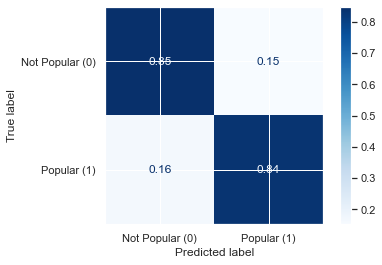

In [23]:
model_performance(model_log, X_train, X_test, y_train, y_test, pred)

Notes:
* Model has accuracy of 70% 
* Issues predicting popular songs. Too many false negatives and false positives

### ROC Curve and AUC
"ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s."

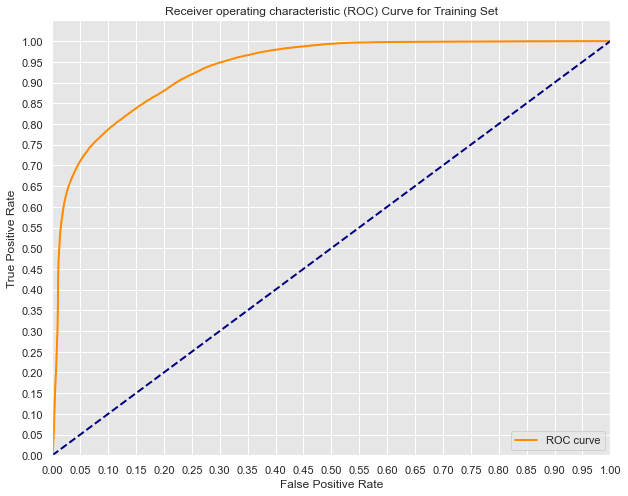

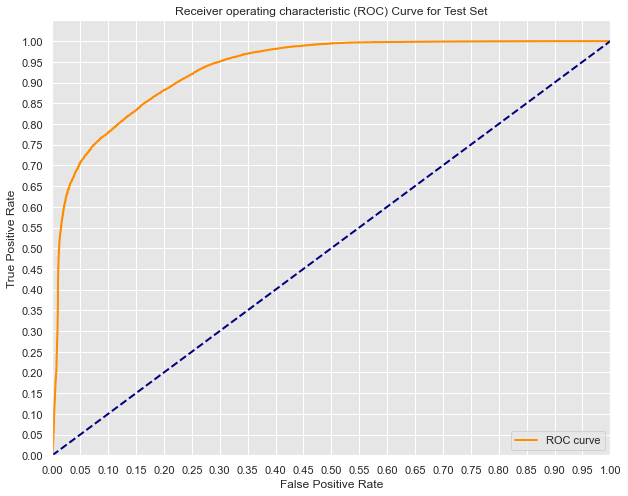

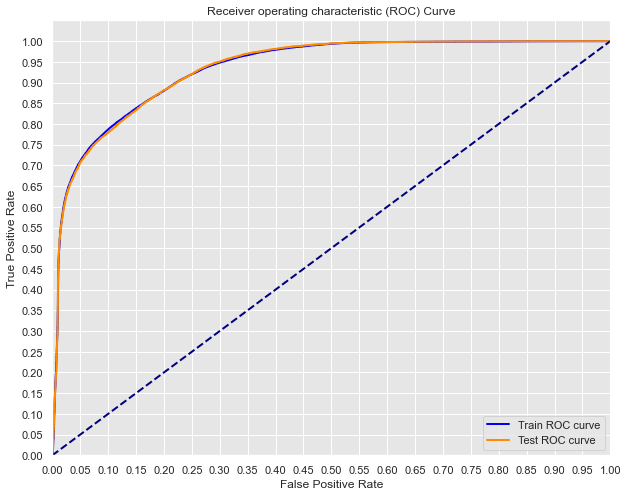

Train AUC: 0.9344531719606197
Test AUC: 0.9344014569678618


In [24]:
roc_auc(model_log, X_train, X_test, y_train, y_test)

AUC is looking pretty good but could be better. Also the ROC curve could be more perpendicular

***
## LR Model 2: LogisticRegressionCV

### Instantiate classifier and fit model

In [25]:
logreg = LogisticRegressionCV()
model_logcv = logreg.fit(X_train, y_train)
model_logcv

LogisticRegressionCV()

### Model  coefficients

In [26]:
find_coeffs(model_logcv, X_train, X)

,coef
year,2.868504
loudness,0.301682
valence,0.070000
duration_ms,0.019608
key,0.003841
acousticness,-0.029482
danceability,-0.029924
tempo,-0.036650
liveness,-0.116954
instrumentalness,-0.157427


### Predict

In [27]:
pred = logreg.predict(X_test)

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.85      0.85      0.85     22069
     Popular       0.84      0.84      0.84     20595

    accuracy                           0.84     42664
   macro avg       0.84      0.84      0.84     42664
weighted avg       0.84      0.84      0.84     42664



----------------------------------------------------------
Training Accuracy Score: 84.42%
Testing Accuracy Score: 84.2%
Accuracy: 84.2%


----------------------------------------------------------


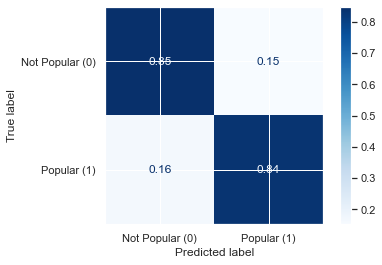

In [28]:
model_performance(model_logcv, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

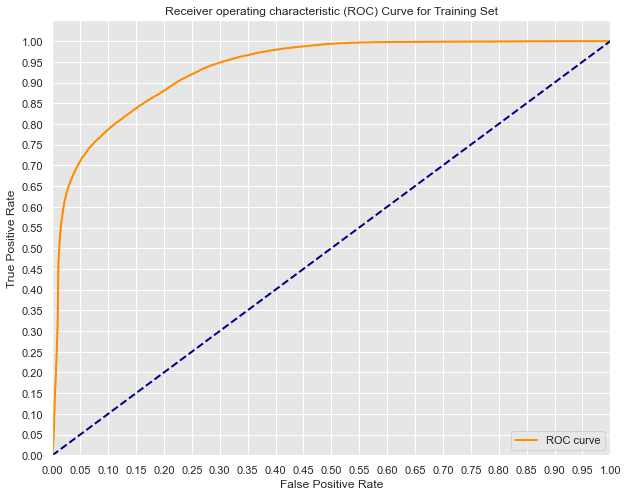

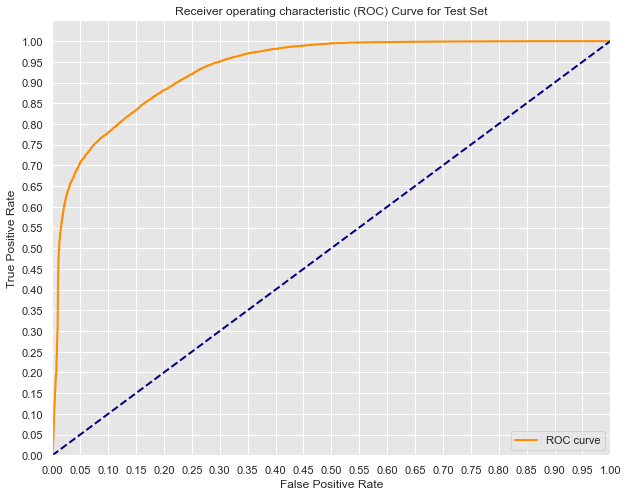

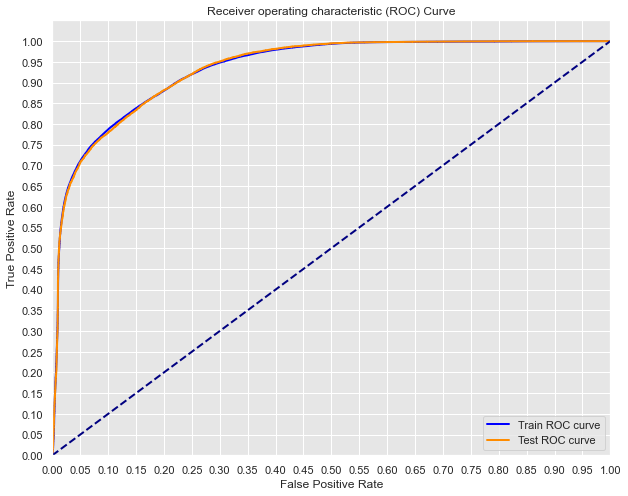

Train AUC: 0.9344536880052569
Test AUC: 0.9344022204256396


In [29]:
roc_auc(model_logcv, X_train, X_test, y_train, y_test)

***
## LR Model 3: GridSearchCV

### Instantiate classifier

In [30]:
# logreg = LogisticRegression()

### Create Parameter Grid 

In [31]:
# log_param_grid = {
#     'penalty' : ['l1', 'l2'],
#     'C' : [1.0, 2.0, 3.0, 4.0],
#     'solver' : ['liblinear']
# }

### Instantiate GridSearchCV and fit

In [32]:
# gs_log = GridSearchCV(logreg, log_param_grid, cv=3, return_train_score=True,
#                       n_jobs=-1)

In [33]:
# best_param = gs_log.fit(X_train, y_train)

### Look at best parameters

In [34]:
# print("Best Parameter Combination Found During Grid Search:")
# best_param.best_params_

### Predict

In [35]:
# pred = best_param.predict(X_test)

### Model Performance

In [36]:
# model_performance(logreg, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

In [37]:
# roc_auc(best_param, X_train, X_test, y_train, y_test)

***
# Decision Trees Models
***

## DT Model 1: Baseline DecisionTree Model

### Instantiate classifier and fit model

In [38]:
dtree_clf = DecisionTreeClassifier() 
dtree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

### Predict

In [39]:
pred = dtree_clf.predict(X_test)

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.81      0.81      0.81     22069
     Popular       0.80      0.80      0.80     20595

    accuracy                           0.80     42664
   macro avg       0.80      0.80      0.80     42664
weighted avg       0.80      0.80      0.80     42664



----------------------------------------------------------
Training Accuracy Score: 99.78%
Testing Accuracy Score: 80.4%
Accuracy: 80.4%


----------------------------------------------------------


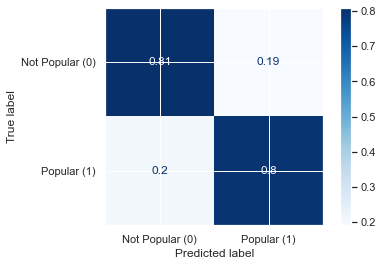

In [40]:
model_performance(dtree_clf, X_train, X_test, y_train, y_test, pred)

### Feature Importances

year                0.612431
duration_ms         0.043807
tempo               0.040349
loudness            0.038900
liveness            0.038610
danceability        0.037314
speechiness         0.036831
acousticness        0.036627
valence             0.035386
energy              0.034065
instrumentalness    0.028439
key                 0.017241
dtype: float64

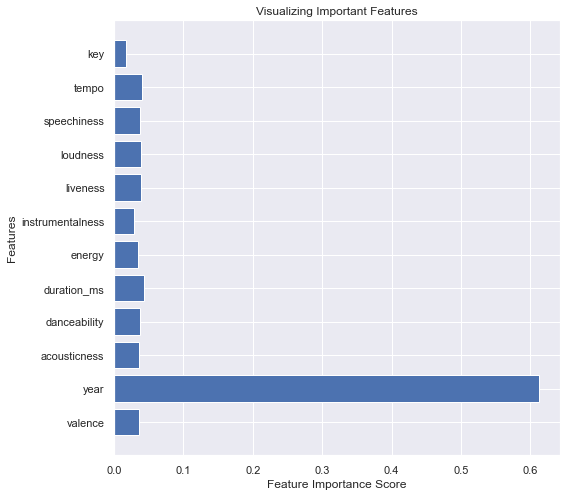

In [41]:
plot_feature_importances(dtree_clf, X_train, X)

### ROC Curve and AUC

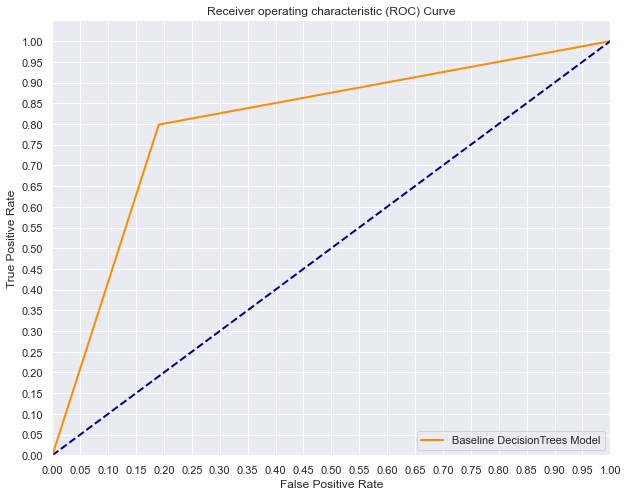

AUC: 0.8038420704640508


In [42]:
label = 'Baseline DecisionTrees Model'

roc_dt_rf(y_test, pred, label=label)

***
## DT Model 2: Bagged DecisionTree

### Instantiate classifier and fit

In [43]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier())
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier())

### Predict

In [44]:
pred = bagged_tree.predict(X_test)

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.82      0.88      0.85     22069
     Popular       0.86      0.79      0.82     20595

    accuracy                           0.84     42664
   macro avg       0.84      0.84      0.84     42664
weighted avg       0.84      0.84      0.84     42664



----------------------------------------------------------
Training Accuracy Score: 98.88%
Testing Accuracy Score: 83.68%
Accuracy: 83.68%


----------------------------------------------------------


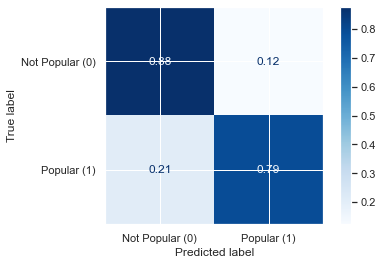

In [45]:
model_performance(bagged_tree, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

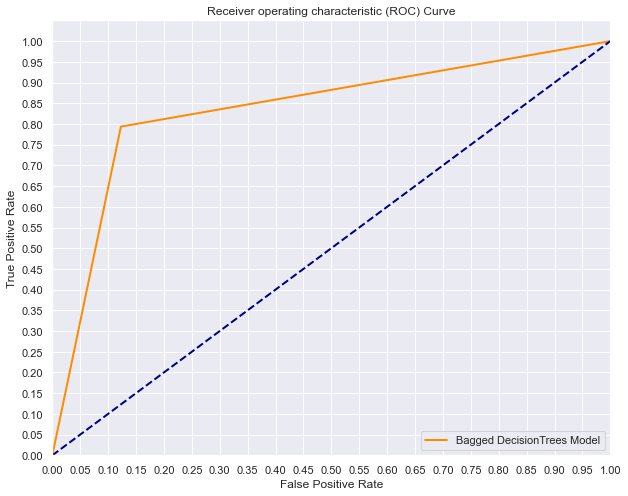

AUC: 0.835351684680145


In [46]:
label = 'Bagged DecisionTrees Model'

roc_dt_rf(y_test, pred, label=label)

***
## DT Model 3: DecisionTree GridSearch 

### Instantiate classifier

In [47]:
dtree_model = DecisionTreeClassifier() 

### Create Parameter Grid

In [48]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

### Instantiate GridSearchCV and fit

In [49]:
dt_grid_search = GridSearchCV(dtree_model, dt_param_grid, cv=3,
                              return_train_score=True, n_jobs=-1)

In [50]:
best_param = dt_grid_search.fit(X_train, y_train)

### Best parameters

In [51]:
print("Best Parameter Combination Found During Grid Search:")
best_param.best_params_

Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

### Predict

In [52]:
pred = best_param.predict(X_test)

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.84      0.87      0.85     22069
     Popular       0.85      0.82      0.83     20595

    accuracy                           0.84     42664
   macro avg       0.84      0.84      0.84     42664
weighted avg       0.84      0.84      0.84     42664



----------------------------------------------------------
Training Accuracy Score: 84.82%
Testing Accuracy Score: 84.33%
Accuracy: 84.33%


----------------------------------------------------------


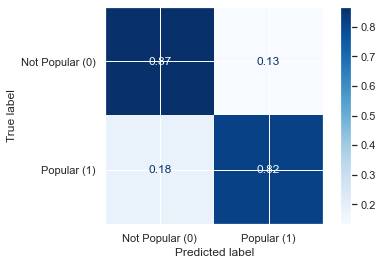

In [53]:
model_performance(best_param, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

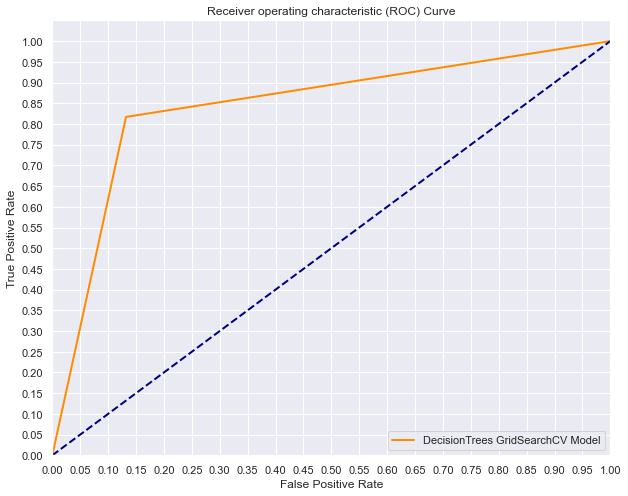

AUC: 0.8424559640249014


In [54]:
label = 'DecisionTrees GridSearchCV Model'

roc_dt_rf(y_test, pred, label=label)

***
# Random Forests Models
***

## RF Model 1: Baseline Model

### Instantiate classifier and fit

In [55]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

### Predict

In [56]:
pred = forest.predict(X_test)

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.84      0.87      0.86     22069
     Popular       0.86      0.82      0.84     20595

    accuracy                           0.85     42664
   macro avg       0.85      0.85      0.85     42664
weighted avg       0.85      0.85      0.85     42664



----------------------------------------------------------
Training Accuracy Score: 99.77%
Testing Accuracy Score: 84.75%
Accuracy: 84.75%


----------------------------------------------------------


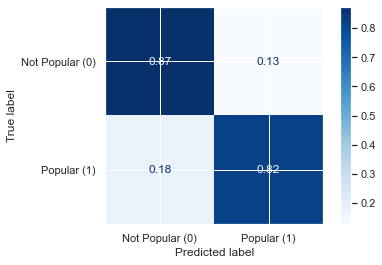

In [57]:
model_performance(forest, X_train, X_test, y_train, y_test, pred)

Notes:
* Model has accuracy of 85% 
* Issues predicting popular songs. Too many false negatives and false positives

### ROC Curve and AUC

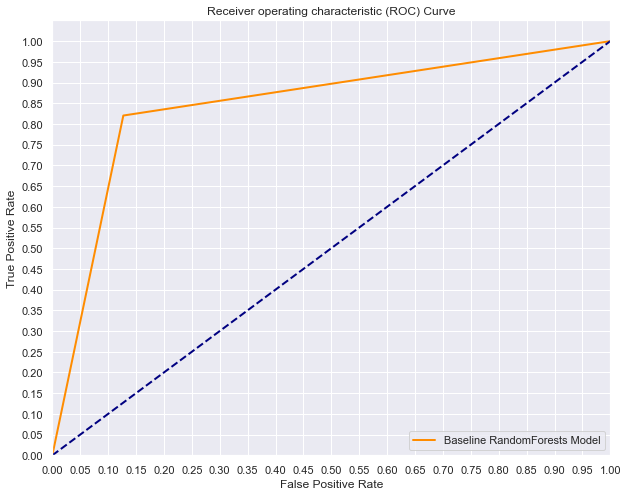

AUC: 0.8465537213390772


In [58]:
label = 'Baseline RandomForests Model'
roc_dt_rf(y_test, pred, label=label)

***
## RF Model 2: GridSearchCV Model

### Instantiate classifier

In [59]:
rforest_model = RandomForestClassifier()

### Create Parameter Grid

In [60]:
rf_param_grid = {
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

### Instantiate GridSearchCV and fit

In [61]:
rf_grid_search = GridSearchCV(rforest_model, rf_param_grid, cv=3,
                            return_train_score=True, n_jobs=-1)

In [62]:
best_param = rf_grid_search.fit(X_train, y_train)

### Best parameters

In [63]:
print("Best Parameter Combination Found During Grid Search:")
best_param.best_params_

Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 100}

### Predict

In [64]:
pred = best_param.predict(X_test)

### Model Performance

Classification Report 
               precision    recall  f1-score   support

 Not Popular       0.84      0.87      0.86     22069
     Popular       0.86      0.82      0.84     20595

    accuracy                           0.85     42664
   macro avg       0.85      0.85      0.85     42664
weighted avg       0.85      0.85      0.85     42664



----------------------------------------------------------
Training Accuracy Score: 94.61%
Testing Accuracy Score: 84.72%
Accuracy: 84.72%


----------------------------------------------------------


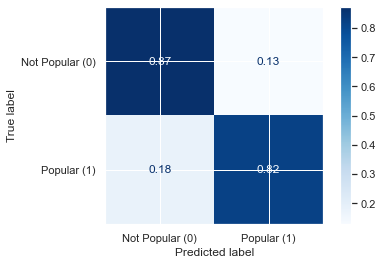

In [65]:
model_performance(best_param, X_train, X_test, y_train, y_test, pred)

### ROC Curve and AUC

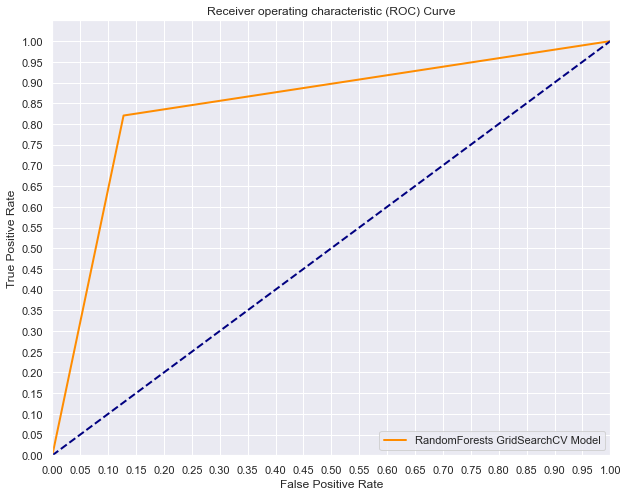

AUC: 0.8463498154076803


In [66]:
label = 'RandomForests GridSearchCV Model'

roc_dt_rf(y_test, pred, label=label)